In [29]:
%%HTML
<link rel="stylesheet" href="rise.css">

# <span style="color:teal"> Data assimilation, machine learning and dynamical systems - Part II </span>
#### Marc Bocquet¹ [marc.bocquet@enpc.fr](mailto:marc.bocquet@enpc.fr) and Alban Farchi¹ [alban.farchi@enpc.fr](mailto:alban.farchi@enpc.fr)
#### (1) CEREA, École des Ponts and EdF R&D, IPSL, Île-de-France, France

During this session, we will apply standard machine learning methods to learn the dynamics of the Lorenz 1996 model.

## <span style="color:green"> The Lorenz 1996 model </span>

The Lorenz 1996 (L96, [Lorenz and Emanuel 1998](https://journals.ametsoc.org/view/journals/atsc/55/3/1520-0469_1998_055_0399_osfswo_2.0.co_2.xml)) is a low-order chaotic model commonly used in data assimilation to asses the performance of new algorithms. It represents the evolution of some unspecified scalar meteorological quantity (perhaps vorticity or temperature) over a latitude circle.

The model **dynamics** is driven by the following set of ordinary differential equations (ODEs):
$$
    \forall n \in [1, N_{x}], \quad \frac{\mathrm{d}x_{n}}{\mathrm{d}t} =
    (x_{n+1}-x_{n-2})x_{n-1}-x_{n}+F,
$$
where the indices are periodic: $x_{-1}=x_{N_{x}-1}$, $x_{0}=x_{N_{x}}$, and $x_{1}=x_{N_{x}+1}$, and where the system size $N_{x}$ can take arbitrary values.

In the standard configuration, $N_{x}=40$ and the forcing coefficient is $F=8$. The ODEs are integrated using a fourth-order Runge-Kutta scheme with a time step of $0.05$ model time unit (MTU). The resulting dynamics is **chaotic** with a doubling time of errors around $0.42$ MTU (the corresponding Lyapunov is hence $0.61$ MTU). For comparison, $0.05$ MTU represent six hours of real time and correspond to an average autocorrelation around $0.967$. Finally, the model variability (spatial average of the time standard deviation per variable) is $3.64$.

## <span style="color:green"> The true model dynamics </span>

In this series of experiments, we will try to emulate the dynamics of the L96 model using artificial neural networks (NN).
1. We start by running the **true model** to build a training dataset.
2. We build and **train a NN** using this dataset.
3. We evaluate the **forecast skill** of the surrogate model (the NN).

### <span style="color:blue"> Importing all modules </span>

In [30]:
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm, trange

import utils

utils.set_style()
seeds = [3, 31, 314, 3141, 31415, 314159, 3141592, 31415926]

### <span style="color:blue"> Defining the neural network model </span>

In the following cell, we define the true Lorenz 1996 model using standard values: 
- the number of variables $N_{x}$ is set to `Nx=40`;
- the forcing coefficient $F$ is set to `F=8`;
- the integration time step is set to `dt=0.05`.

In [31]:
# create model
true_model = utils.Lorenz1996Model(Nx=40, dt=0.05, F=8)

# save some statistics about the model
true_model.model_var = 3.64
true_model.doubling_time = 0.42
true_model.lyap_time = 0.61

### <span style="color:blue"> Short model integration </span>

In the following cells, we perform a rather short model integration, in order to illustrate the model dynamics. The initial condition is a random field.

In [32]:
# define rng
rng = np.random.default_rng(seed=seeds.pop(0))

# allocate memory
Nt_plot = 500
xt_plot = np.zeros((Nt_plot+1, true_model.Nx))

# initialisation and integrate
xt_plot[0] = rng.normal(loc=3, scale=1, size=true_model.Nx)
for t in trange(Nt_plot, desc='model integration'):
    xt_plot[t+1] = true_model.forward(xt_plot[t])

model integration:   0%|          | 0/500 [00:00<?, ?it/s]

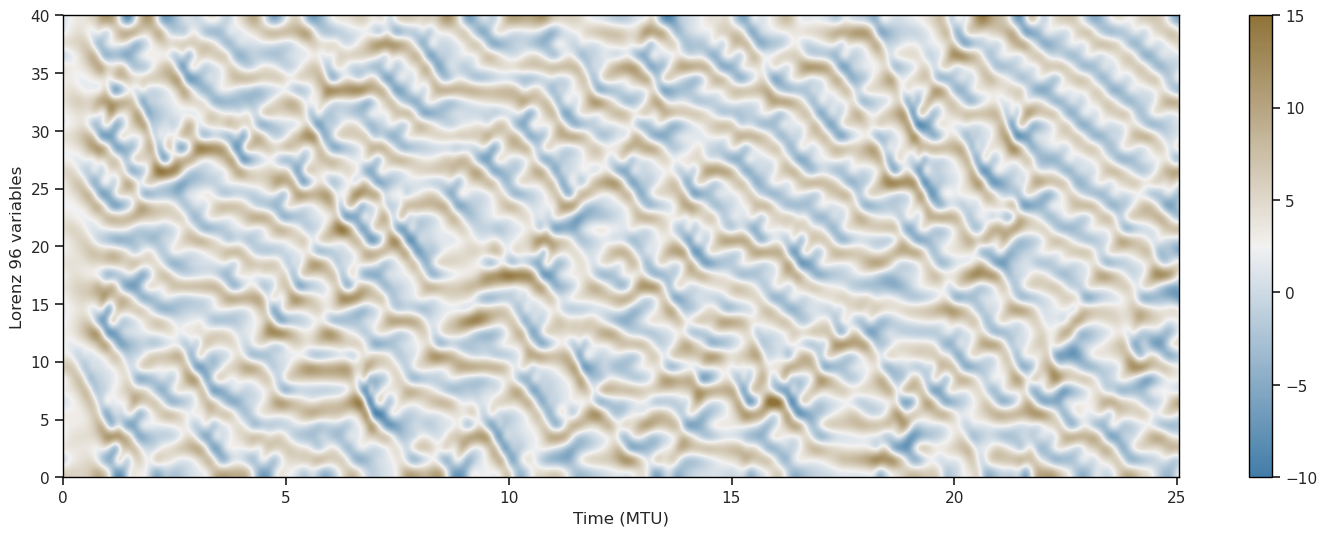

In [33]:
utils.plot_l96_traj(
    xt_plot, 
    true_model,
    linewidth=18,
)

We see first a spin-up period of about $1$ MTU, where the initial condition is progressively forgotten and the trajectory progressively gets back to the model attractor. After this spin-up period, the dynamics is characterised by waves moving slowly towards the east (i.e. decreasing variable index). 

## <span style="color:green"> Prepare the dataset </span>

### <span style="color:blue"> A long model integration for the training data</span>

We now use a true model trajectory to make the **training dataset**. This trajectory starts from a random field (different than for the plotting trajectory) and we discard the first $100$ time steps to get rid of the spin-up process.

In [34]:
# define rng
rng = np.random.default_rng(seed=seeds.pop(0))

# allocate memory
Nt_train = 10000
Nt_spinup = 100
xt_train = np.zeros((Nt_train+1, true_model.Nx))

# initialisation and spin-up
xt_train[0] = rng.normal(loc=3, scale=1, size=true_model.Nx)
for t in trange(Nt_spinup, desc='spin-up integration'):
    xt_train[0] = true_model.forward(xt_train[0])

# model integration
for t in trange(Nt_train, desc='model integration (train)'):
    xt_train[t+1] = true_model.forward(xt_train[t])

spin-up integration:   0%|          | 0/100 [00:00<?, ?it/s]

model integration (train):   0%|          | 0/10000 [00:00<?, ?it/s]

### <span style="color:blue"> Preprocess the training data </span>

The training dataset is made of input/output pairs, where the input is the state at a given time, and the output is the state at the following time.

In [35]:
# make input/output pairs: input = xt[t], output = xt[t+1]
x_train_raw = xt_train[:-1]
y_train_raw = xt_train[1:]

The training dataset is then **normalised** and **split** into training and validation data. For our experiments, we keep one tenth of the data for validation.

In [36]:
# normalise the training data using numpy's broadcasting rules
x_mean = x_train_raw.mean(axis=0)
y_mean = y_train_raw.mean(axis=0)
x_std = x_train_raw.std(axis=0)
y_std = y_train_raw.std(axis=0)
def normalise_x(x):
    return (x - x_mean)/x_std
def normalise_y(y):
    return (y - y_mean)/y_std
def denormalise_x(x_norm):
    return x_norm*x_std + x_mean
def denormalise_y(y_norm):
    return y_norm*y_std + y_mean
x_train_raw_norm = normalise_x(x_train_raw)
y_train_raw_norm = normalise_y(y_train_raw)

# split into training / validation
index_train = np.array([i for i in range(Nt_train) if i%10])
index_valid = np.array([i for i in range(Nt_train) if not i%10])
x_train_norm = x_train_raw_norm[index_train]
y_train_norm = y_train_raw_norm[index_train]
x_valid_norm = x_train_raw_norm[index_valid]
y_valid_norm = y_train_raw_norm[index_valid]

### <span style="color:blue"> A shorter model integration for the test data</span>

We repeat the same process to make the **test dataset**. In this case, the trajectory starts from another random field (and we still get rid of the spin-up process) and can be somewhat shorter, but the normalisation must be the same as for the training dataset.

In [37]:
# define rng
rng = np.random.default_rng(seed=seeds.pop(0))

# allocate memory
Nt_test = 1000
Nt_spinup = 100
xt_test = np.zeros((Nt_test+1, true_model.Nx))

# initialisation and spin-up
xt_test[0] = rng.normal(loc=3, scale=1, size=true_model.Nx)
for t in trange(Nt_spinup, desc='spin-up integration'):
    xt_test[0] = true_model.forward(xt_test[0])

# model integration
for t in trange(Nt_test, desc='model integration (test)'):
    xt_test[t+1] = true_model.forward(xt_test[t])

# make input/output pairs: input = xt[t], output = xt[t+1]
x_test = xt_test[:-1]
y_test = xt_test[1:]

# normalise the test data using numpy's broadcasting rules
x_test_norm = normalise_x(x_test)
y_test_norm = normalise_y(y_test)

spin-up integration:   0%|          | 0/100 [00:00<?, ?it/s]

model integration (test):   0%|          | 0/1000 [00:00<?, ?it/s]

### <span style="color:blue"> An ensemble model integration for the forecast skill data</span>

In order to assess the forecast skill of the surrogate model, we will use a different test dataset, in which we record an ensemble of **trajectories** (instead of an ensemble of input/output pairs). This will allow us to measure the accuracy of the forecast for longer integration times.

In [38]:
# define rng
rng = np.random.default_rng(seed=seeds.pop(0))

# allocate memory
Nt_fs = 400
Nt_spinup = 100
Ne_fs = 512
xt_fs = np.zeros((Nt_fs+1, Ne_fs, true_model.Nx))

# initialisation and spin-up
xt_fs[0] = rng.normal(loc=3, scale=1, size=(Ne_fs, true_model.Nx))
for t in trange(Nt_spinup, desc='spin-up integration'):
    xt_fs[0] = true_model.forward(xt_fs[0])
    
# model integration
for t in trange(Nt_fs, desc='model integration (ensemble)'):
    xt_fs[t+1] = true_model.forward(xt_fs[t])

spin-up integration:   0%|          | 0/100 [00:00<?, ?it/s]

model integration (ensemble):   0%|          | 0/400 [00:00<?, ?it/s]

## <span style="color:green"> The baseline model: persistence </span>

In this first test series, we use **persistence** as surrogate model. This will provide baselines for our NN results. Persistence is defined as the model for which there is no time evolution.

### <span style="color:blue"> Evaluate the model</span>

The mean square error (MSE) is the loss function that we will use to train our NNs later. Therefore, the test MSE is a measure of the efficiency of the learning/training process.

The test MSE of persistence is a number whose absolute value is not that important per se (because the input and output data have been normalised) but it will be useful to normalise the test MSE of our trained NNs.

In [39]:
# compute test MSE
test_mse_baseline = np.mean(np.square(y_test_norm - x_test_norm))

# compute forecast skill
fs_baseline = np.sqrt(np.mean(np.square(xt_fs-xt_fs[0]), axis=2))

# show test MSE
print(f'test mse of persistence = {test_mse_baseline}')

test mse of persistence = 0.06183308040943624


### <span style="color:blue"> Example of surrogate model integration</span>

In the following cell, we show one example of model integration.

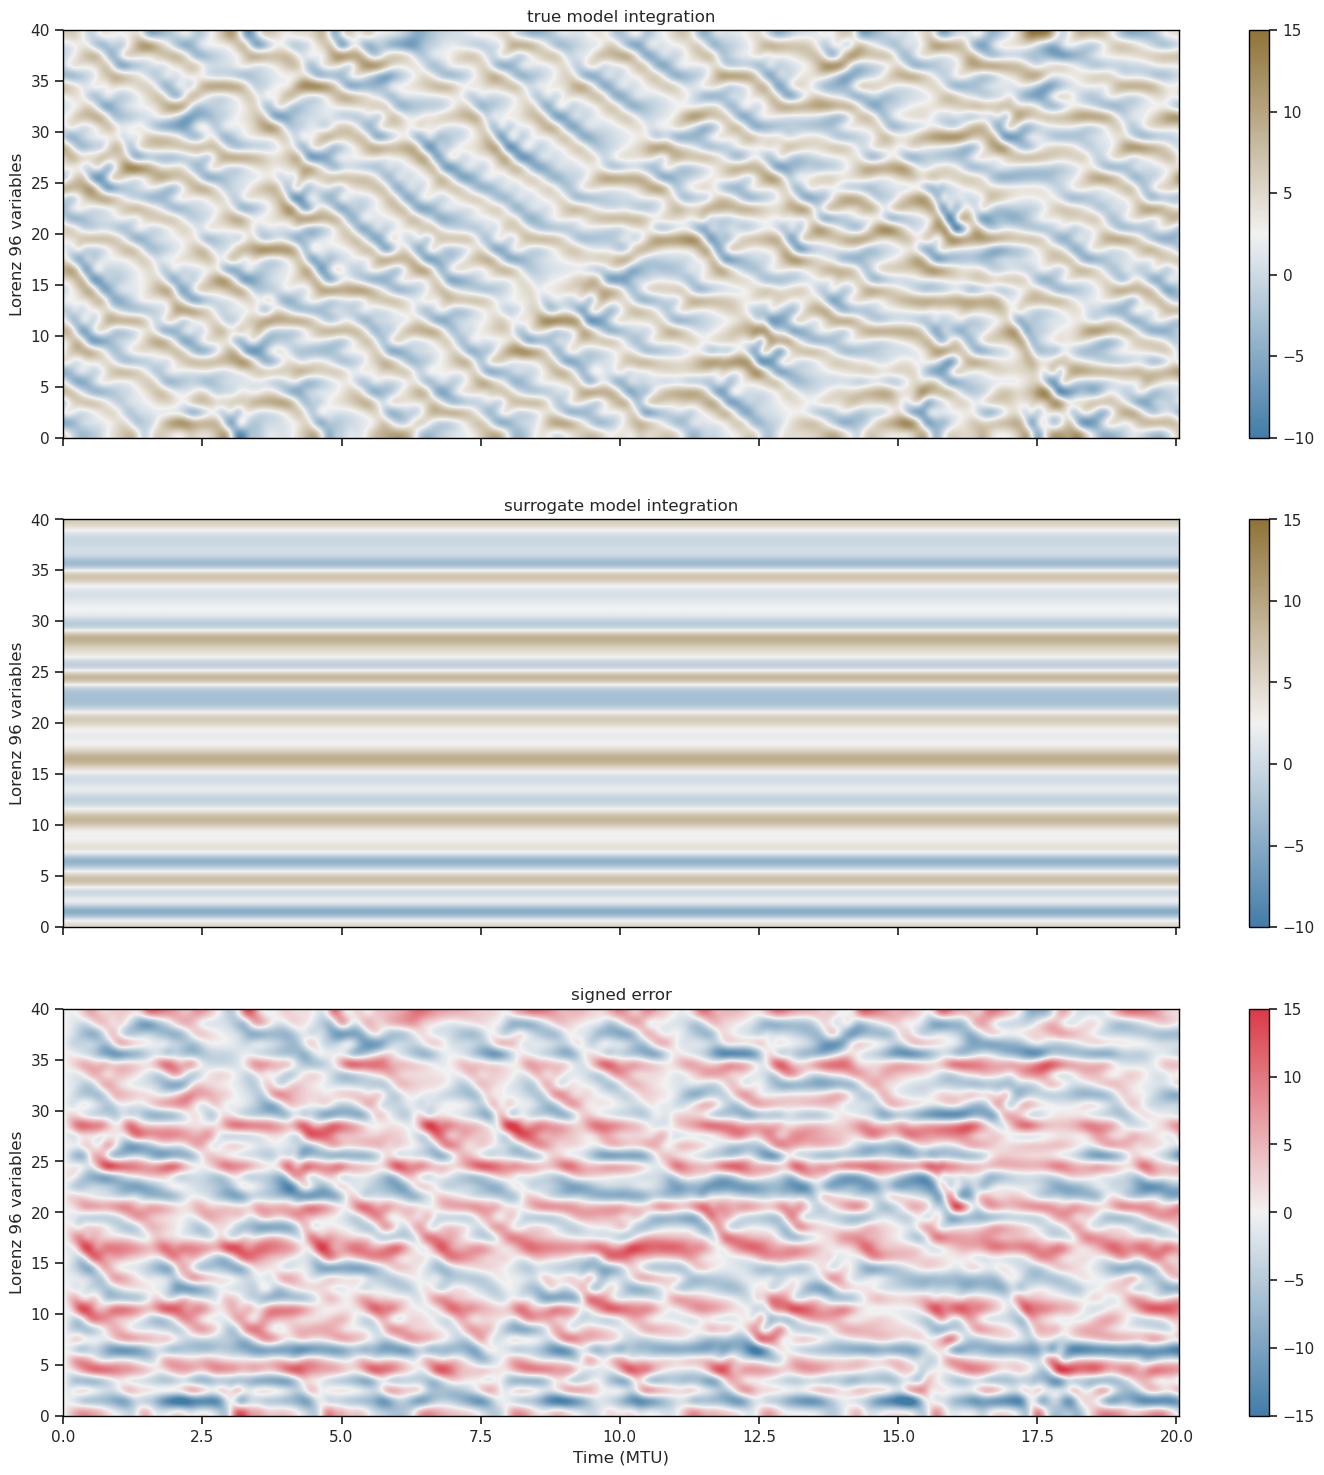

In [40]:
utils.plot_l96_compare_traj(
    xt_fs[:, 0],
    np.broadcast_to(xt_fs[0, 0], shape=xt_fs[:, 0].shape),
    true_model,
    linewidth=18,
)

### <span style="color:blue"> Forecast skill</span>

In the following cell, we plot the average forecast skill, normalised by the model variability. The shadow delimits the 90% confidence interval (percentiles 5 and 95).

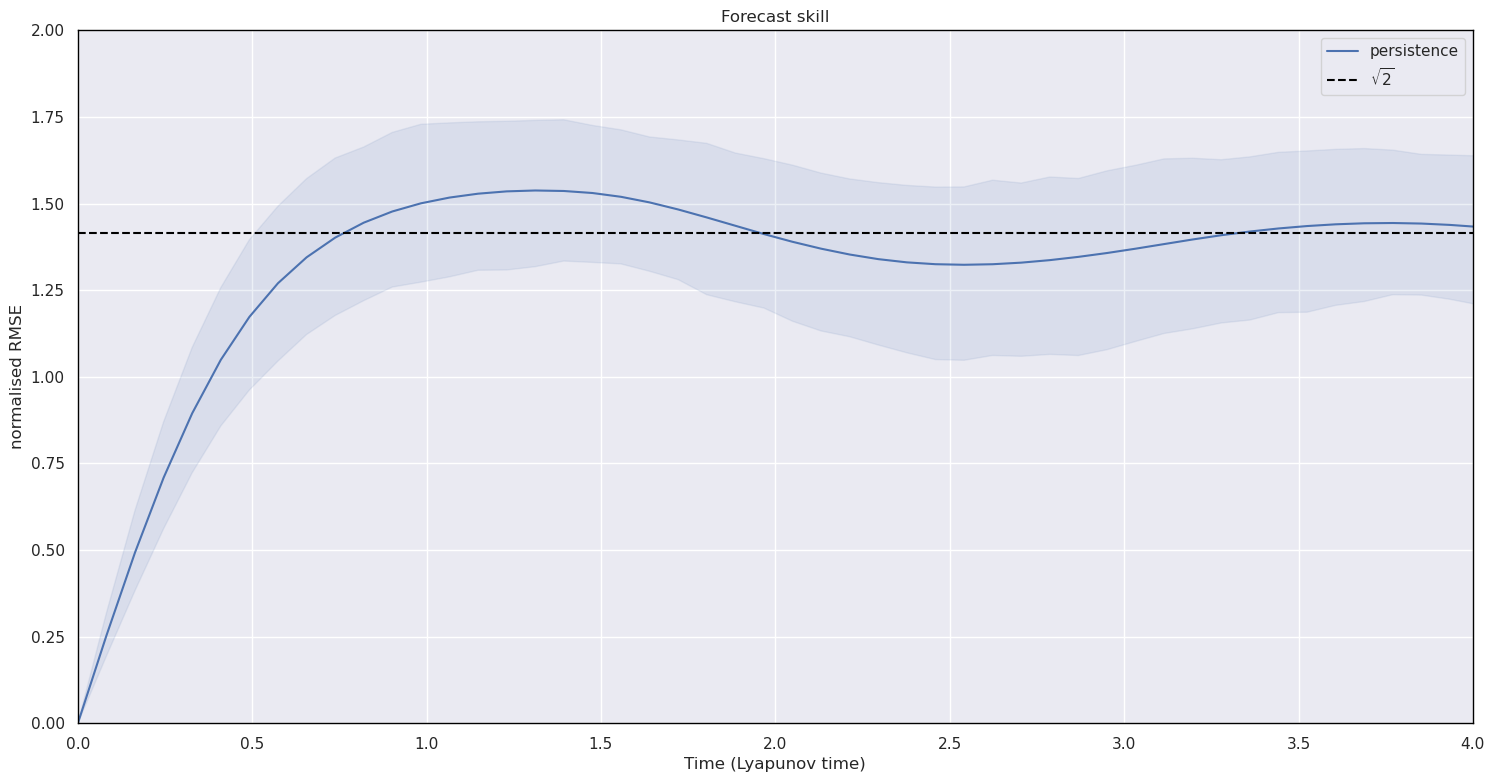

In [41]:
utils.plot_l96_forecast_skill(
    dict(
        persistence=fs_baseline,
    ),
    true_model,
    p1=5,
    p2=95,
    xmax=4,
    linewidth=18,
)

The error rapidly grows as time evolves. After about $1$ Lyapunov time, the error oscillates around $\sqrt{2}$, which is the theoretical asymptotic value due to the normalisation and which is consistent with the wave behaviour of the dynamics.

## <span style="color:green"> A naive ML model </span>

### <span style="color:blue"> Construct and train the model</span>

In this second test series, we train and evaluate a dense NN (sequential NN with only dense layers). In order to create this model, we use the sequential API of tensorflow as follows.

In [42]:
def make_sequential_network(num_layers, num_nodes, activation):
    # create a sequential network
    network = tf.keras.models.Sequential()
    # add the input layers
    network.add(tf.keras.Input(shape=(true_model.Nx,)))
    # add the internal layers
    for i in range(num_layers):
        network.add(tf.keras.layers.Dense(num_nodes, activation=activation))
    # add the output layer without activation
    network.add(tf.keras.layers.Dense(true_model.Nx))
    return network

In the following cell, we actually build a dense NN with $4$ internal layers and $128$ nodes per layer. The total number of parameters of this model is $59944$. This is actually quite large for a $40$-variable system. This is because the dense architecture is rather "inefficient" in terms of parameters.

In [43]:
# set seed
tf.keras.utils.set_random_seed(seeds.pop(0))

# define the NN
num_layers = 4
num_nodes = 128
activation = 'relu'
naive_network = make_sequential_network(num_layers, num_nodes, activation)

# compilation
naive_network.compile(loss='mse', optimizer='adam')

# print short summary
naive_network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               5248      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 40)                5160      
                                                                 
Total params: 59,944
Trainable params: 59,944
Non-trainable params: 0
_________________________________________________________________


In the following cell, we actually train the model for $256$ epochs. Going beyond part I, we use an EarlyStopping callback to end the training when the validation loss stops improving. This should avoid overfitting.

In [44]:
# train the ML model
tf.keras.utils.set_random_seed(seeds.pop(0))
num_epochs = 256
tqdm_callback = utils.tqdm_callback(num_epochs, 'naive NN training')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=16,
    verbose=0,
    restore_best_weights=True,
)
fit_naive = naive_network.fit(
    x_train_norm, 
    y_train_norm,
    verbose=0,
    epochs=num_epochs, 
    validation_data=(x_valid_norm, y_valid_norm),
    callbacks=[tqdm_callback, early_stopping_callback],
)

naive NN training:   0%|          | 0/256 [00:00<?, ?it/s]

In the following cell we plot the training history, that is, the evolution of the training MSE (the `loss`) and the validation MSE (the `val_loss`) as a function of the number of epochs.

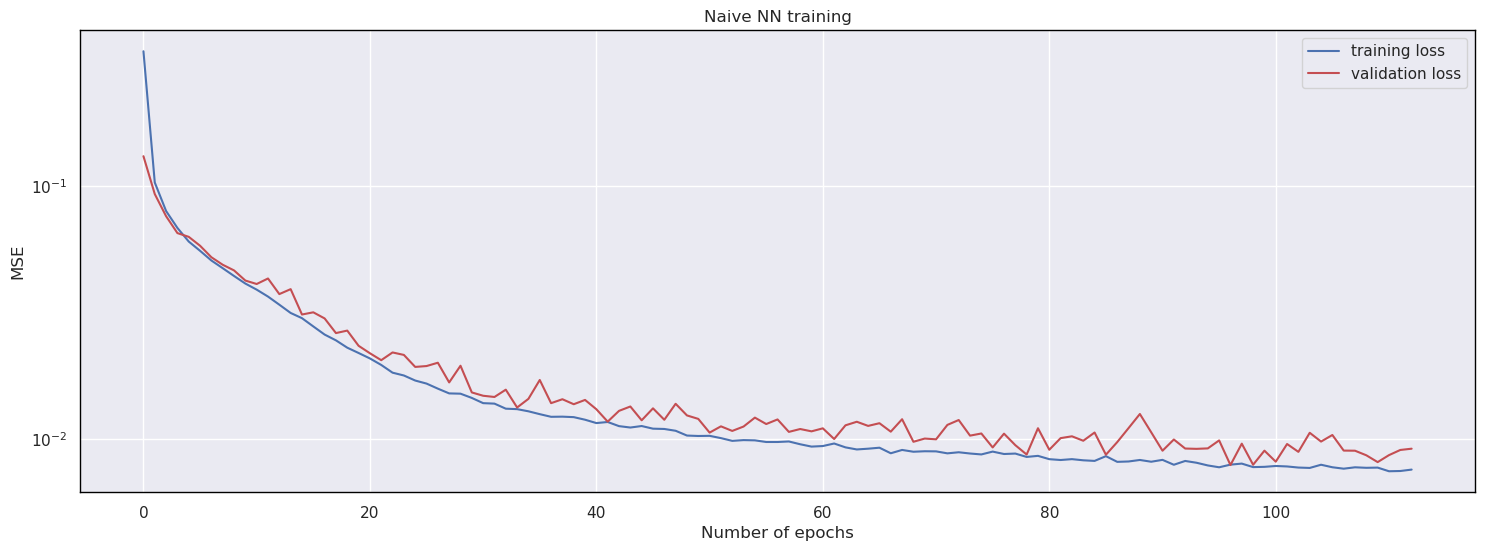

In [45]:
utils.plot_learning_curve(
    fit_naive.history['loss'],
    fit_naive.history['val_loss'],
    title='Naive NN training',
    linewidth=18,
)

Both values are visually closely related. The validation MSE is more noisy than the training MSE, which is expected because the training data is nine times as large as the validation data. After several epochs, the validation MSE gets a bit higher than the training MSE. This is explained by the fact that this data is not used in the gradient descent algorithm. Finally, at the end the validation MSE stops improving. This is the sign that the model is starting to overfit the training data and that we should stop the training.

### <span style="color:blue"> Evaluate the model</span>

We now compute the test MSE to evaluate our surrogate model. 

In [46]:
# compute test MSE
test_mse_naive = naive_network.evaluate(x_test_norm, y_test_norm, verbose=0, batch_size=Nt_test)

# compute forecast skill
xt_naive = np.zeros(xt_fs.shape)
xt_naive[0] = xt_fs[0]
for t in trange(xt_naive.shape[0]-1, desc='naive surrogate model integration'):
    x_norm = normalise_x(xt_naive[t])
    y_norm = naive_network.predict(x_norm, batch_size=Ne_fs, verbose=0)
    xt_naive[t+1] = denormalise_y(y_norm)
fs_naive = np.sqrt(np.mean(np.square(xt_fs-xt_naive), axis=2))

# show test MSE
print(f'test mse of persistence = {test_mse_baseline}')
print(f'test mse of naive model = {test_mse_naive}')
print()
print(f'relative test mse of naive model = {test_mse_naive/test_mse_baseline}')

naive surrogate model integration:   0%|          | 0/400 [00:00<?, ?it/s]

test mse of persistence = 0.06183308040943624
test mse of naive model = 0.01143017690628767

relative test mse of naive model = 0.18485536917457748


We obtain a reduction of about 80%, which is already quite good, but we will see later that it is possible to do much better.

### <span style="color:blue"> Example of surrogate model integration</span>

In the following cell, we show once again one example of model integration.

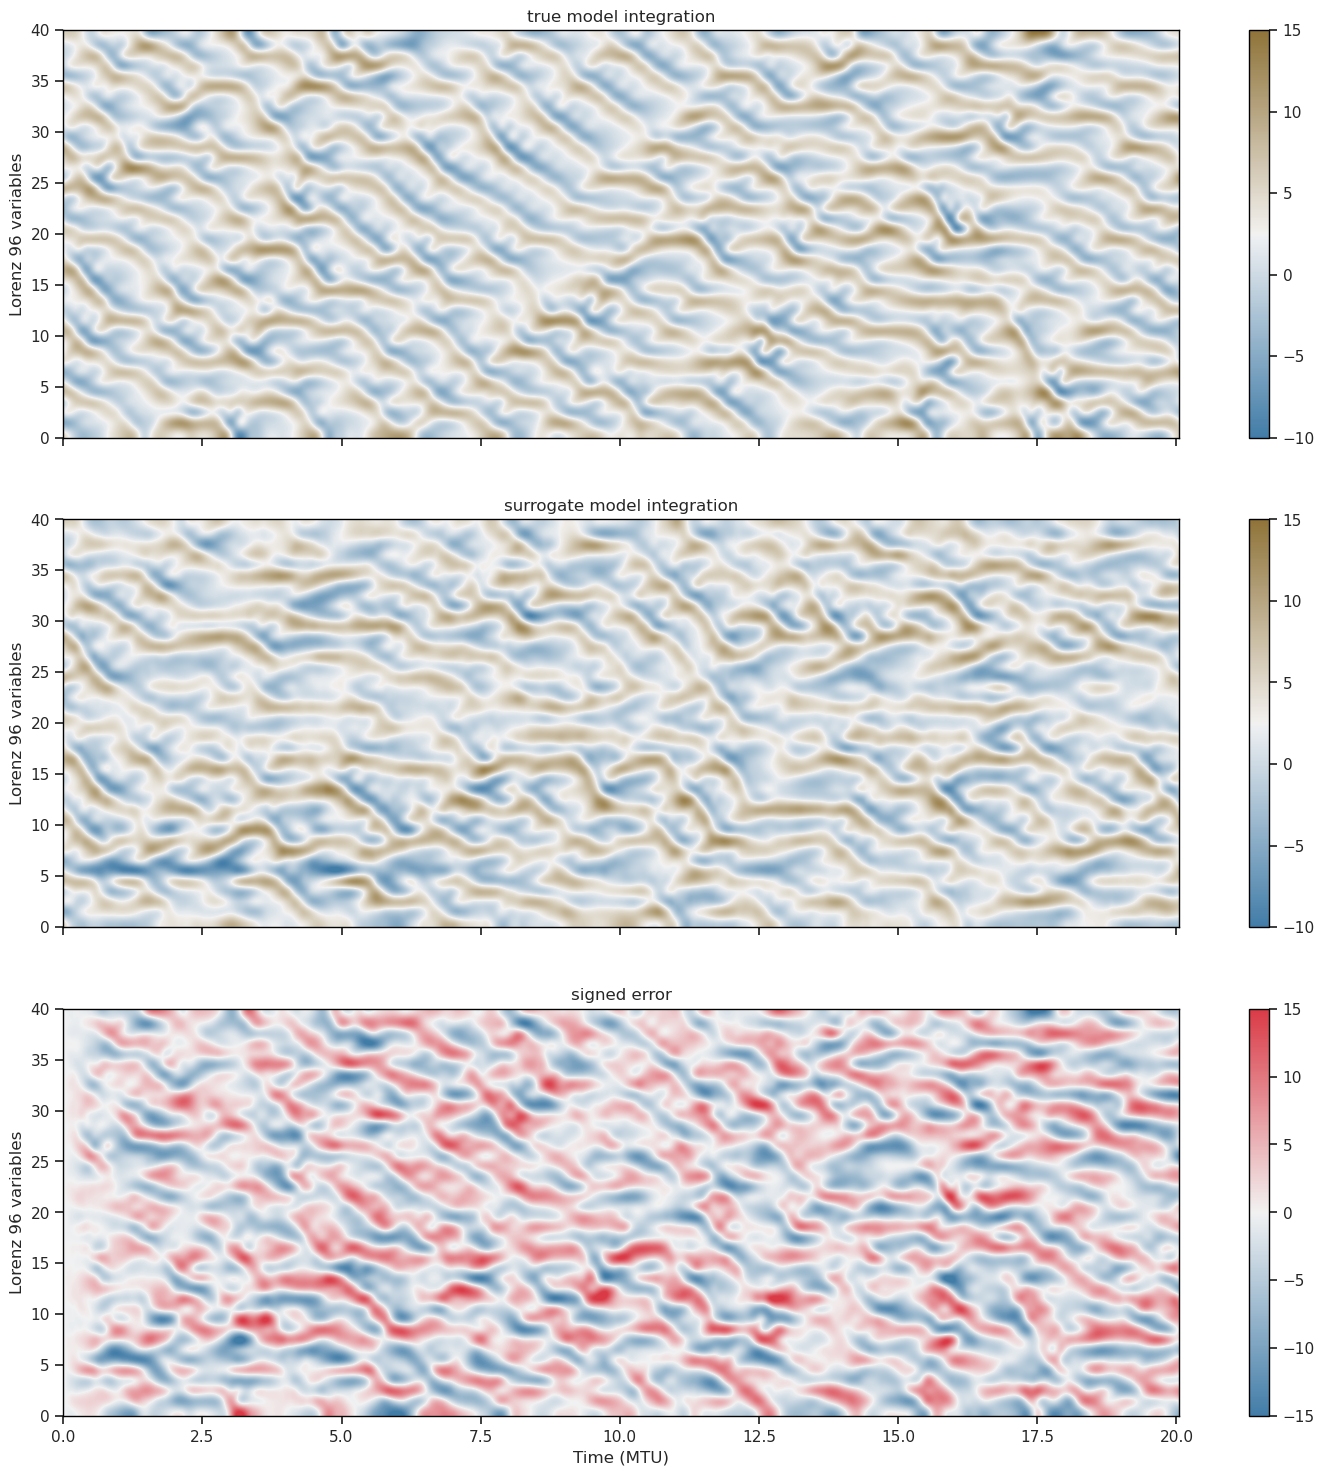

In [47]:
utils.plot_l96_compare_traj(
    xt_fs[:, 0],
    xt_naive[:, 0],
    true_model,
    linewidth=18,
)

The error is lower than in the first test series, but only during the first few integration steps.

### <span style="color:blue"> Forecast skill</span>

In the following cell, we plot once again the average forecast skill, normalised by the model variability.

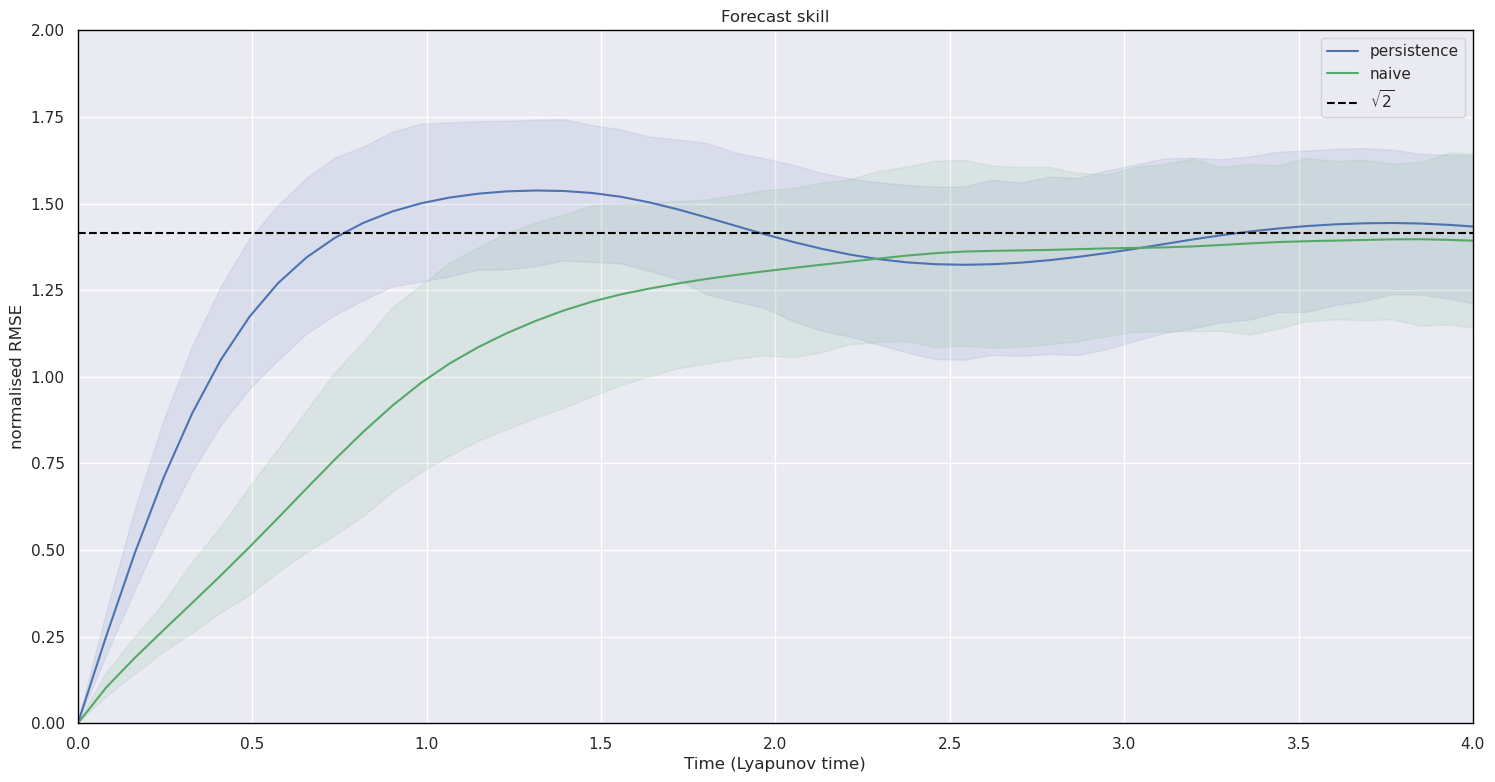

In [48]:
utils.plot_l96_forecast_skill(
    dict(
        persistence=fs_baseline,
        naive=fs_naive,
    ),
    true_model,
    p1=5,
    p2=95,
    xmax=4,
    linewidth=18,
)

This curve confirms that the naive surrogate model is more accurate than persistence for one integration step, and that it remains more accurate until about $2$ Lyapunov times.

## <span style="color:green"> A smart ML model </span>

### <span style="color:blue"> Build and train the model</span>

In this third and last test series, we train and evaluate a smart NN. This NN uses a sparse architecture with convolutional NN and controlled nonlinearity to reproduce the **model tendencies**, as well as a Runge-Kutta integration scheme to **emulate the dynamics**. In order to implement this NN, we use both the functional API (for the model tendency) and the subclassing API (for the integration scheme) of tensorflow.

In [49]:
class SmartNetwork(tf.keras.Model):
    
    def __init__(self, num_filters, kernel_size, dt=0.05, **kwargs):
        super(SmartNetwork, self).__init__(**kwargs)
        self.dt = dt
        
        # reshape layers
        reshape_input = tf.keras.layers.Reshape((true_model.Nx, 1))
        reshape_output = tf.keras.layers.Reshape((true_model.Nx,))
        
        # padding layer
        border = kernel_size//2
        def apply_padding(x):
            x_left = x[..., -border:, :]
            x_right = x[..., :border, :]
            return tf.concat([x_left, x, x_right], axis=-2)
        padding_layer = tf.keras.layers.Lambda(apply_padding)
        
        # convolutional layers
        conv_layer_1 = tf.keras.layers.Conv1D(num_filters, kernel_size)
        conv_layer_2 = tf.keras.layers.Conv1D(1, 1)
        
        # network for the model tendencies
        x_in = tf.keras.Input(shape=(true_model.Nx,))
        x = reshape_input(x_in)
        x = padding_layer(x)
        x1 = conv_layer_1(x)
        x2 = x1 * x1
        x3 = tf.concat([x1, x2], axis=-1)
        x_out = conv_layer_2(x3)
        x_out = reshape_output(x_out)
        self.tendency = tf.keras.Model(inputs=x_in, outputs=x_out)
    
    @tf.function
    def call(self, x):
        dx_dt_0 = self.tendency(x)
        dx_dt_1 = self.tendency(x+0.5*self.dt*dx_dt_0)
        dx_dt_2 = self.tendency(x+0.5*self.dt*dx_dt_1)
        dx_dt_3 = self.tendency(x+self.dt*dx_dt_2)
        dx_dt =  (dx_dt_0 + 2*dx_dt_1 + 2*dx_dt_2 + dx_dt_3)/6
        return x + self.dt*dx_dt

In [50]:
# set seed
tf.keras.utils.set_random_seed(seeds.pop(0))

# define the NN
num_filters = 6
kernel_size = 5
smart_network = SmartNetwork(num_filters, kernel_size, dt=true_model.dt)

# compilation
smart_network.compile(loss='mse', optimizer='adam')

# print short summary
smart_network.tendency.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 40, 1)        0           ['input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 44, 1)        0           ['reshape_2[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 6)        36          ['lambda_1[0][0]']               
                                                                                            

The total number of parameters is only $49$. Furthermore in this case, with well-chosen parameters it is possible to reproduce the true dynamics up to machine precision: the model is said to be **identifiable**. Also note that this network is built in such a way that we don't need the input and output data to be normalised.

In the following cell, we actually train the model for up to $128$ epochs. Once again, we use an EarlyStopping callback to end the training when the validation loss stops improving in order to avoid overfitting.

In [51]:
# train the ML model
tf.keras.utils.set_random_seed(seeds.pop(0))
num_epochs = 128
tqdm_callback = utils.tqdm_callback(num_epochs, 'smart NN training')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=16,
    verbose=0,
    restore_best_weights=True)
fit_smart = smart_network.fit(
    denormalise_x(x_train_norm),
    denormalise_y(y_train_norm),
    verbose=0,
    epochs=num_epochs, 
    validation_data=(denormalise_x(x_valid_norm), denormalise_y(y_valid_norm)),
    callbacks=[tqdm_callback, early_stopping_callback])

smart NN training:   0%|          | 0/128 [00:00<?, ?it/s]

In the following cell we plot the training history.

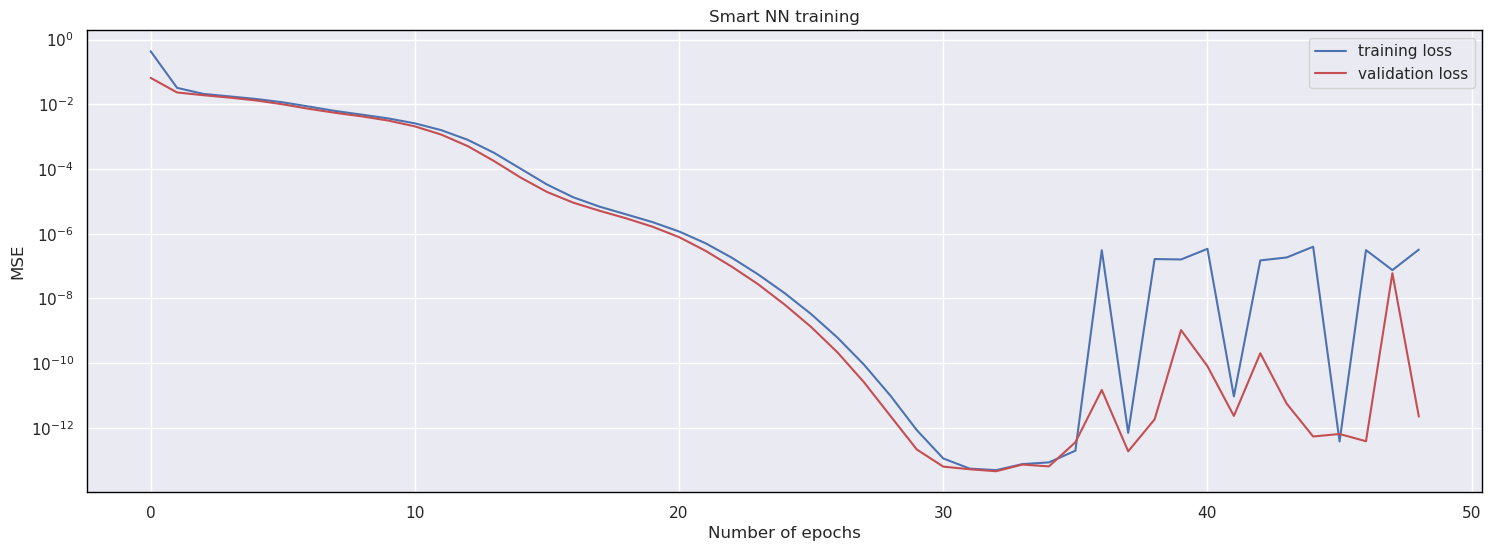

In [52]:
utils.plot_learning_curve(
    fit_smart.history['loss'],
    fit_smart.history['val_loss'],
    title='Smart NN training',
    linewidth=18,
)

Once again, the training and validation MSE are visually closely related. However, by contrast with the previous test series, after about $30$ epochs, the MSEs have decreased to $10^{-12}$, which should be very close to the numerical precision zero (tensorflow is working on simple precision for real numbers). Passed $30$ epochs, the MSEs oscillate at very low values. This behaviour can be considered as numerical noise.

### <span style="color:blue"> Evaluate the model</span>

We now compute the test MSE to evaluate our surrogate model. 

In [53]:
# compute test MSE
y_test_smart = smart_network.predict(denormalise_x(x_test_norm), batch_size=Nt_test, verbose=0)
test_mse_smart = np.mean(np.square(normalise_y(y_test_smart)-y_test_norm))

# compute forecast skill
xt_smart = np.zeros(xt_fs.shape)
xt_smart[0] = xt_fs[0]
for t in trange(xt_smart.shape[0]-1, desc='smart surrogate model integration'):
    xt_smart[t+1] = smart_network.predict(xt_smart[t], batch_size=Ne_fs, verbose=0)
fs_smart = np.sqrt(np.mean(np.square(xt_fs-xt_smart), axis=2))

# show test MSE
print(f'test mse of persistence = {test_mse_baseline}')
print(f'test mse of naive model = {test_mse_naive}')
print(f'test mse of smart model = {test_mse_smart}')
print()
print(f'relative test mse of naive model = {test_mse_naive/test_mse_baseline}')
print(f'relative test mse of smart model = {test_mse_smart/test_mse_baseline}')

smart surrogate model integration:   0%|          | 0/400 [00:00<?, ?it/s]

test mse of persistence = 0.06183308040943624
test mse of naive model = 0.01143017690628767
test mse of smart model = 2.5158712658520378e-15

relative test mse of naive model = 0.18485536917457748
relative test mse of smart model = 4.068811143149994e-14


The test MSE is sufficiently close to zero so that we can consider that our surrogate model reproduces the true model dynamics up to numerical precision.

### <span style="color:blue"> Example of surrogate model integration</span>

In the following cell, we show once again one example of model integration.

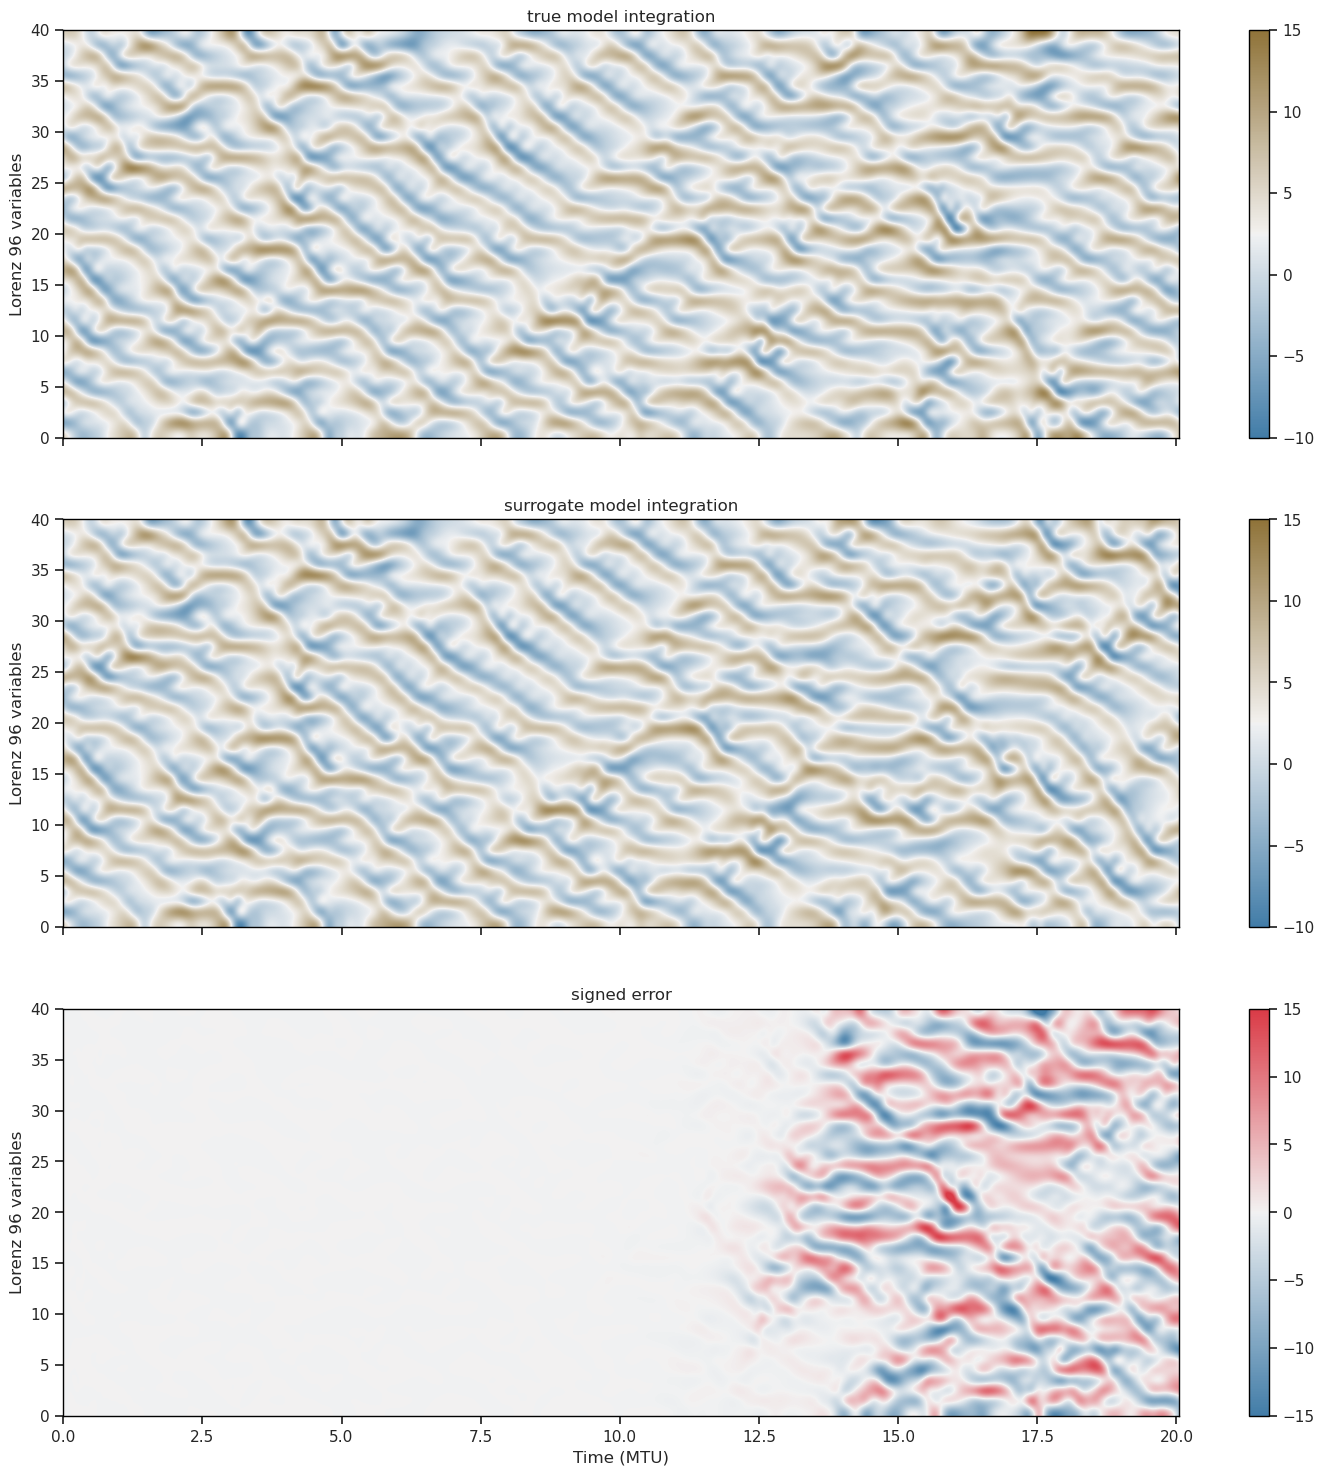

In [54]:
utils.plot_l96_compare_traj(
    xt_fs[:, 0],
    xt_smart[:, 0],
    true_model,
    linewidth=18,
)

This time, the error is so low that it is not visible until about $6$ MTU. At that time, the true model trajectory and the surrogate model trajectory diverge from each other. Indeed, the two models are equivalent up to numerical precision, but they are not bit-wise equivalent, which means that this divergence is unavoidable because of the chaotic nature of the dynamics. 

### <span style="color:blue"> Forecast skill</span>

In the following cell, we plot once again the average forecast skill, normalised by the model variability.

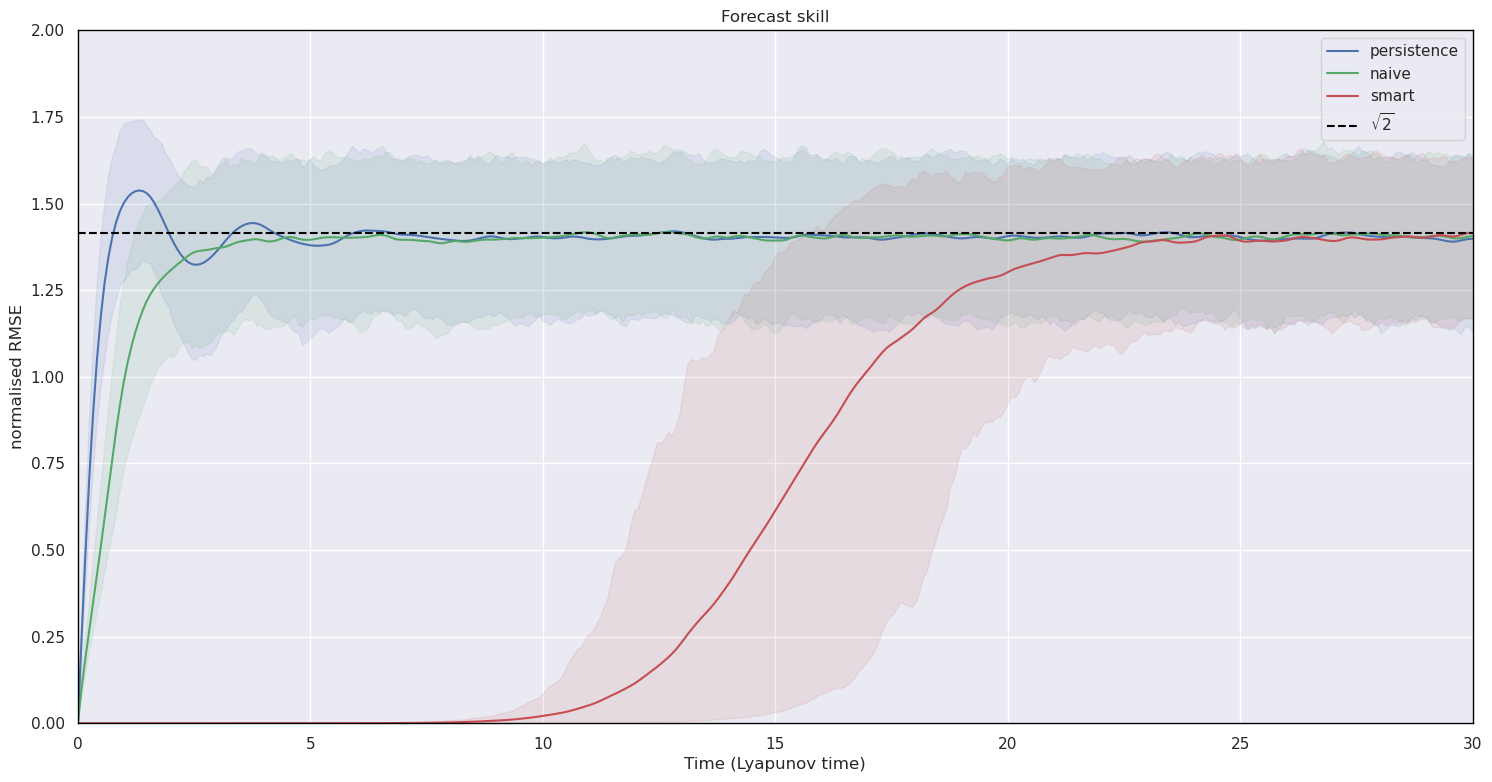

In [55]:
utils.plot_l96_forecast_skill(
    dict(
        persistence=fs_baseline,
        naive=fs_naive,
        smart=fs_smart,
    ),
    true_model,
    p1=5,
    p2=95,
    xmax=30,
    linewidth=18,
)

This curve confirms that the the smart surrogate model is equivalent to the true model up to numerical precision. The numerical divergence between the true and surrogate model happens on average after about $10$ Lyapunov times.